# 3. [Sélection et évaluation de modèle](https://scikit-learn.org/stable/model_selection.html)

3.1. Validation croisée : évaluer les performances des estimateurs
* 3.1.1. Calcul de métriques à validation croisée
* 3.1.2. Itérateurs de validation croisée
* 3.1.3. Une note sur le brassage
* 3.1.4. Validation croisée et sélection de modèles
* 3.1.5. Résultat du test de permutation

3.2. Réglage des hyper-paramètres d'un estimateur
* 3.2.1. Recherche exhaustive sur la grille
* 3.2.2. Optimisation aléatoire des paramètres
* 3.2.3. Recherche de paramètres optimaux par halving successifs
* 3.2.4. Conseils pour la recherche de paramètres
* 3.2.5. Alternatives à la recherche de paramètres par force brute

3.3. Métriques et scoring : quantifier la qualité des prédictions
* 3.3.1. Le paramètre scoring : définir les règles d'évaluation du modèle
* 3.3.2. Métriques de classification
* 3.3.3. Métriques de classement multi-étiquettes
* 3.3.4. Métriques de régression
* 3.3.5. Métriques de clustering
* 3.3.6. Estimateurs factices

3.4. Courbes de validation : tracer des scores pour évaluer des modèles
* 3.4.1. Courbe de validation
* 3.4.2. Courbe d'apprentissage

# 3.1. Validation croisée : évaluer les performances des estimateurs

Apprendre les paramètres d'une fonction de prédiction et la tester sur les mêmes données est une erreur méthodologique : un modèle qui se contenterait de répéter les étiquettes des échantillons qu'il vient de voir aurait un score parfait mais ne parviendrait pas à prédire quoi que ce soit d'utile sur de nouvelles données. Cette situation s'appelle le **surajustement**. Pour l'éviter, il est courant lors de la réalisation d'une expérience d'apprentissage automatique (supervisée) de conserver une partie des données disponibles sous forme d'**ensemble de test** `X_test`, `y_test`. Notez que le mot "expérience" n'est pas destiné à désigner uniquement un usage académique, car même dans les environnements commerciaux, l'apprentissage automatique commence généralement de manière expérimentale. Voici un organigramme du flux de travail typique de validation croisée dans l'entraînement de modèles. Les meilleurs paramètres peuvent être déterminés par des techniques de [recherche sur grille](https://scikit-learn.org/stable/modules/grid_search.html#grid-search).

Flux de travail de recherche sur grille
![](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

Dans scikit-learn, une répartition aléatoire en ensembles d'apprentissage et de test peut être rapidement calculée avec la fonction utilitaire [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split). Chargeons l'ensemble de données d'iris pour y adapter une machine à vecteurs de support linéaire :

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

X, y = datasets.load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

Nous pouvons désormais échantillonner rapidement un ensemble d'apprentissage tout en conservant 40 % des données pour tester (évaluer) notre classifieur :

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

X_train.shape, y_train.shape
# ((90, 4), (90,))
X_test.shape, y_test.shape
# ((60, 4), (60,))

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9666666666666667

Lors de l'évaluation de différents paramètres ("hyperparamètres") pour les estimateurs, tels que le paramètre `C` qui doit être défini manuellement pour une SVM, il existe toujours un risque de surapprentissage sur l'*ensemble de test* car les paramètres peuvent être modifiés jusqu'à ce que l'estimateur fonctionne de manière optimale. De cette façon, les connaissances sur l'ensemble de test peuvent "s'infiltrer" dans le modèle et les métriques d'évaluation ne rendent plus compte des performances de généralisation. Pour résoudre ce problème, une autre partie encore de l'ensemble de données peut être considérée comme un soi-disant "ensemble de validation": l'entraînement se déroule sur l'ensemble d'entraînement, après quoi l'évaluation est effectuée sur l'ensemble de validation, et quand l'expérience semble être réussie, l'évaluation finale peut être effectuée sur l'ensemble de test.

Cependant, en partitionnant les données disponibles en trois ensembles, nous réduisons considérablement le nombre d'échantillons qui peuvent être utilisés pour entraîner le modèle, et les résultats peuvent dépendre d'un choix aléatoire particulier pour la paire d'ensembles (train, validation).

Une solution à ce problème est une procédure appelée [wkpd : validation croisée](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) (CV en abrégé). Un ensemble de test doit toujours être conservé pour l'évaluation finale, mais l'ensemble de validation n'est plus nécessaire lors de la réalisation de CV. Dans l'approche de base, appelée $k$-fold CV, l'ensemble d'apprentissage est divisé en $k$ ensembles plus petits (d'autres approches sont décrites ci-dessous, mais suivent généralement les mêmes principes). La procédure suivante est suivie pour chacun des $k$ « plis » :

* Un modèle est entraîné à l'aide de $k - 1$ des plis comme données d'apprentissage ;
* le modèle résultant est validé sur la partie restante des données (c'est-à-dire qu'il est utilisé comme ensemble de test pour calculer une mesure de performance telle que la précision).

La mesure de performance rapportée par la validation croisée $k$-fold est alors la moyenne des valeurs calculées dans la boucle. Cette approche peut être coûteuse en calcul, mais ne gaspille pas trop de données (comme c'est le cas lors de la fixation d'un ensemble de validation arbitraire), ce qui est un avantage majeur dans des problèmes tels que l'inférence inverse où le nombre d'échantillons est très petit.

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

## 3.1.1. Calcul de métriques à validation croisée

La manière la plus simple d'utiliser la validation croisée consiste à appeler la fonction utilitaire [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) sur l'estimateur et l'ensemble de données.

L'exemple suivant montre comment estimer la précision d'une machine à vecteurs de support à noyau linéaire sur l'ensemble de données iris en divisant les données, en ajustant un modèle et en calculant le score 5 fois consécutives (avec des divisions différentes à chaque fois) :

In [4]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=5)
scores

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

Le score moyen et l'écart type sont alors donnés par :

In [5]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.98 accuracy with a standard deviation of 0.02


Par défaut, le score calculé à chaque itération de CV est la méthode de score de l'estimateur. Il est possible de changer cela en utilisant le paramètre scoring :

In [6]:
from sklearn import metrics
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
scores

array([0.96658312, 1.        , 0.96658312, 0.96658312, 1.        ])

Voir [3.3 Le paramètre de scoring : définir les règles d'évaluation du modèle](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) pour plus de détails. Dans le cas de l'ensemble de données Iris, les échantillons sont équilibrés entre les classes cibles, d'où le fait que la précision et le score F1 sont presque égaux.

Lorsque l'argument `cv` est un entier, [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) utilise par défaut les stratégies [`KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) ou [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold), cette dernière étant utilisée si l'estimateur dérive de [`ClassifierMixin`](https://scikit-learn.org/stable/modules/generated/sklearn.base.ClassifierMixin.html#sklearn.base.ClassifierMixin).

Il est également possible d'utiliser d'autres stratégies de validation croisée en passant un itérateur de validation croisée à la place, par exemple :

In [7]:
from sklearn.model_selection import ShuffleSplit
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(clf, X, y, cv=cv)

array([0.97777778, 0.97777778, 1.        , 0.95555556, 1.        ])

Une autre option consiste à utiliser des fractionnements de 'yielding' itérables (train, test) en tant que tableaux d'indices, par exemple :

In [8]:
def custom_cv_2folds(X):
    n = X.shape[0]
    i = 1
    while i <= 2:
        idx = np.arange(n * (i - 1) / 2, n * i / 2, dtype=int)
        yield idx, idx
        i += 1

custom_cv = custom_cv_2folds(X)
cross_val_score(clf, X, y, cv=custom_cv)

array([1.        , 0.97333333])

**Transformation de données avec des données conservées**

Tout comme il est important de tester un prédicteur sur les données d'entraînement retenues, le prétraitement (comme la normalisation, la sélection de caractéristiques, etc.) et les [transformations de données](https://scikit-learn.org/stable/data_transforms.html#data-transforms) similaires doivent également être apprises à partir d'un ensemble d'entraînement et appliquées aux données retenues pour la prédiction. :

In [9]:
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
clf = svm.SVC(C=1).fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
clf.score(X_test_transformed, y_test)

0.9333333333333333

Un [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) facilite la composition des estimateurs, offrant ce comportement sous validation croisée :

In [10]:
from sklearn.pipeline import make_pipeline
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
cross_val_score(clf, X, y, cv=cv)

array([0.97777778, 0.93333333, 0.95555556, 0.93333333, 0.97777778])

Voir [Pipelines et estimateurs composites](https://scikit-learn.org/stable/modules/compose.html#combining-estimators).

### 3.1.1.1. La fonction `cross_validate` et l'évaluation de métriques multiples

La fonction [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) diffère de [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) de deux manières :

* Il permet de spécifier plusieurs métriques pour l'évaluation.
* Il renvoie un dictionnaire contenant les temps d'ajustement, les temps de score (et éventuellement les scores d'entraînement ainsi que les estimateurs ajustés) en plus du score du test.

Pour une évaluation de métrique unique, où le paramètre de score est une chaîne, appelable ou Aucun, les clés seront - `['test_score', 'fit_time', 'score_time']`

Et pour l'évaluation de métriques multiples, la valeur de retour est un dictionnaire avec les clés suivantes - `['test_<scorer1_name>', 'test_<scorer2_name>', 'test_<scorer...>', 'fit_time', 'score_time']`

`return_train_score` est défini sur `False` par défaut pour gagner du temps de calcul. Pour évaluer également les scores de l'ensemble d'entraînement, vous devez le définir sur `True`.

Vous pouvez également conserver l'estimateur adapté à chaque ensemble d'apprentissage en définissant `return_estimator=True`.

Les multiples métriques peuvent être spécifiées sous la forme d'une liste, d'un tuple ou d'un ensemble de noms d'évaluateurs prédéfinis :

In [11]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['precision_macro', 'recall_macro']
clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores = cross_validate(clf, X, y, scoring=scoring)
sorted(scores.keys())
# ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']
scores['test_recall_macro']

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

Ou en tant que dictionnaire qui associe le nom d'évaluateur à une fonction d'évaluation prédéfinie ou personnalisée :

In [12]:
from sklearn.metrics import make_scorer
scoring = {'prec_macro': 'precision_macro', 'rec_macro': make_scorer(recall_score, average='macro')}
scores = cross_validate(clf, X, y, scoring=scoring, cv=5, return_train_score=True)
sorted(scores.keys())
# ['fit_time', 'score_time', 'test_prec_macro', 'test_rec_macro', 'train_prec_macro', 'train_rec_macro']
scores['train_rec_macro']

array([0.975     , 0.975     , 0.99166667, 0.98333333, 0.98333333])

Voici un exemple de `cross_validate` utilisant une seule métrique :

In [13]:
scores = cross_validate(clf, X, y,
                        scoring='precision_macro', cv=5,
                        return_estimator=True)
sorted(scores.keys())

['estimator', 'fit_time', 'score_time', 'test_score']

### 3.1.1.2. Obtenir des prédictions par validation croisée

La fonction [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) a une interface similaire à [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), mais renvoie, pour chaque élément de l'entrée, la prédiction qui a été obtenue pour cet élément lorsqu'il était dans l'ensemble de test. Seules les stratégies de validation croisée qui affectent tous les éléments à un ensemble de test exactement une fois peuvent être utilisées (sinon, une exception est levée).

**Avertissement**

Remarque sur l'utilisation inappropriée de [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict)

Le résultat de [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) peut être différent de ceux obtenus avec [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) car les éléments sont regroupés de différentes manières. La fonction [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) prend une moyenne sur les plis de validation croisée, tandis que [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) renvoie simplement les étiquettes (ou probabilités) de plusieurs modèles distincts non distingués. Ainsi, [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) n'est pas une mesure appropriée de l'erreur de généralisation.

**La fonction [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) convient pour :**

* Visualisation des prédictions obtenues à partir de différents modèles.
* Mélange de modèles : lorsque les prédictions d'un estimateur supervisé sont utilisées pour former un autre estimateur aux méthodes d'ensemble.

Les itérateurs de validation croisée disponibles sont présentés dans la section suivante.

## Exemples

1. Receiver Operating Characteristic (ROC) avec validation croisée,
2. Élimination récursive des caractéristiques avec validation croisée,
3. Stratégie de refit personnalisée d'une grille de recherche avec validation croisée,
4. Exemple de pipeline pour l'extraction et l'évaluation de caractéristiques de texte,
5. Tracer des prédictions validées croisées,
6. Validation croisée imbriquée versus non imbriquée.

### Ex 1. Caractéristique de fonctionnement du récepteur (ROC) avec validation croisée

Exemple de métrique de caractéristique de fonctionnement du récepteur (**ROC** - *Receiver Operating Characteristic*) pour évaluer la qualité de sortie du classifieur à l'aide de la validation croisée.

Les courbes ROC présentent généralement un taux de vrais positifs sur l'axe Y et un taux de faux positifs sur l'axe X. Cela signifie que le coin supérieur gauche du graphique est le point "idéal" - un taux de faux positifs de zéro et un taux de vrais positifs de un. Ce n'est pas très réaliste, mais cela signifie qu'une plus grande surface sous la courbe (AUC) est généralement meilleure.

La «pente» des courbes ROC est également importante, car elle est idéale pour maximiser le taux de vrais positifs tout en minimisant le taux de faux positifs.

Cet exemple montre la réponse ROC de différents ensembles de données, créés à partir de la validation croisée K-fold. En prenant toutes ces courbes, il est possible de calculer l'aire moyenne sous la courbe et de voir la variance de la courbe lorsque l'ensemble d'apprentissage est divisé en différents sous-ensembles. Cela montre approximativement comment la sortie du classificateur est affectée par les modifications des données d'apprentissage et à quel point les fractionnements générés par la validation croisée K-fold sont différents les uns des autres.

**NB** - Voir aussi 
* [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
* [`sklearn.model_selection.cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)
* [Exemple - Caractéristique de fonctionnement du récepteur (ROC)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py)

#### E/S et génération de données

In [18]:
import numpy as np

from sklearn import datasets

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

#### Classification et analyse ROC

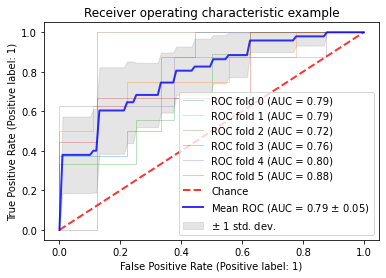

In [19]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

### Ex 1.b Caractéristique de fonctionnement du récepteur (ROC)

Exemple de métrique de caractéristique de fonctionnement du récepteur (**ROC** - *Receiver Operating Characteristic*) pour évaluer la qualité de sortie du classifieur à l'aide de la validation croisée.

Les courbes ROC présentent généralement un taux de vrais positifs sur l'axe Y et un taux de faux positifs sur l'axe X. Cela signifie que le coin supérieur gauche du graphique est le point "idéal" - un taux de faux positifs de zéro et un taux de vrais positifs de un. Ce n'est pas très réaliste, mais cela signifie qu'une plus grande surface sous la courbe (AUC) est généralement meilleure.

La «pente» des courbes ROC est également importante, car elle est idéale pour maximiser le taux de vrais positifs tout en minimisant le taux de faux positifs.

Les courbes ROC sont généralement utilisées dans la classification binaire pour étudier la sortie d'un classifieur. Afin d'étendre la courbe ROC et la zone ROC à la classification multi-étiquettes, il est nécessaire de binariser la sortie. Une courbe ROC peut être tracée par étiquette, mais on peut aussi tracer une courbe ROC en considérant chaque élément de la matrice des indicateurs d'étiquette comme une prédiction binaire (micro-moyenne).

Une autre mesure d'évaluation pour la classification multi-étiquettes est la macro-moyenne, qui donne un poids égal à la classification de chaque étiquette.

**NB** - Voir aussi 
* [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
* [Exemple - Caractéristique de fonctionnement du récepteur (ROC) avec validation croisée](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Tracé d'une courbe ROC pour une classe spécifique

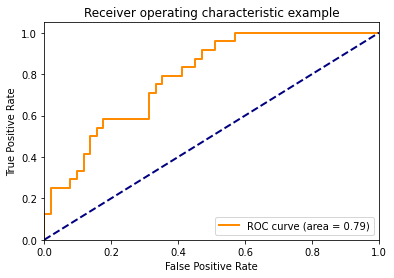

In [15]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

#### Tracé des courbes ROC pour le problème multiclasse

Calculer la courbe ROC macro-moyenne et la zone ROC

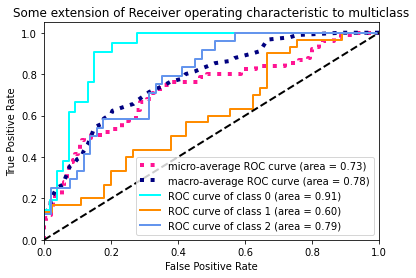

In [16]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

#### Aire sous ROC pour le problème multiclasse

La fonction [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) peut être utilisée pour la classification multi-classes. Le schéma multi-classe One-vs-One compare chaque combinaison par paire unique de classes. Dans cette section, nous calculons l'AUC en utilisant les schémas OvR et OvO. Nous rapportons une moyenne macro et une moyenne pondérée en fonction de la prévalence.

In [17]:
y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.698586 (macro),
0.665839 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.698586 (macro),
0.665839 (weighted by prevalence)


### Élimination récursive des caractéristiques avec validation croisée

Un exemple d'élimination récursive de caractéristiques avec réglage automatique du nombre de caractéristiques sélectionnées avec validation croisée.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_rfe_with_cross_validation_001.png)

Optimal number of features : 3


c:\Users\franc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


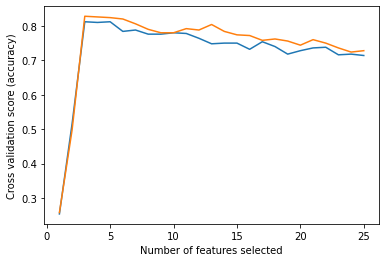

In [21]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
X, y = make_classification(
    n_samples=1000,
    n_features=25,
    n_informative=3,
    n_redundant=2,
    n_repeated=0,
    n_classes=8,
    n_clusters_per_class=1,
    random_state=0,
)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()



### Ex 3. Stratégie de refit personnalisée d'une grille de recherche avec validation croisée

Cet exemple montre comment un classifieur est optimisé par une validation croisée effectuée à l'aide de l'objet [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) sur un ensemble de développement qui ne comprend que la moitié des données étiquetées disponibles.

Les performances des hyper-paramètres sélectionnés et du modèle formé sont ensuite mesurées sur un ensemble d'évaluation dédié qui n'a pas été utilisé lors de l'étape de sélection du modèle.

Plus de détails sur les outils disponibles pour la sélection de modèles peuvent être trouvés dans les sections [Validation croisée : évaluation des performances de l'estimateur et Réglage des hyper-paramètres d'un estimateur](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).

#### Le jeu de données

Nous allons travailler avec le jeu de données `digits`. Le but est de classer les images de chiffres manuscrits. Nous transformons le problème en une classification binaire pour une meilleure compréhension : le but est d'identifier si un chiffre est `8` ou non.

In [23]:
from sklearn import datasets

digits = datasets.load_digits()

Afin de former un classifieur sur des images, nous devons les aplatir en vecteurs. Chaque image de 8 par 8 pixels doit être transformée en un vecteur de 64 pixels. Ainsi, nous obtiendrons un tableau de données final de forme `(n_images, n_pixels)`.

In [24]:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target == 8
print(
    f"The number of images is {X.shape[0]} and each image contains {X.shape[1]} pixels"
)

The number of images is 1797 and each image contains 64 pixels


Comme présenté dans l'introduction, les données seront divisées en un ensemble d'entraînement et un ensemble de test de taille égale.

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

#### Définir notre stratégie de grille de recherche

Nous sélectionnerons un classifieur en recherchant les meilleurs hyper-paramètres sur les plis de l'ensemble d'apprentissage. Pour ce faire, nous devons définir les scores pour sélectionner le meilleur candidat.

In [26]:
scores = ["precision", "recall"]

Nous pouvons également définir une fonction à transmettre au paramètre `refit` de l'instance [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). Il mettra en œuvre la stratégie personnalisée pour sélectionner le meilleur candidat à partir de l'attribut `cv_results_` du [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). Une fois le candidat sélectionné, il est automatiquement réaménagé par l'instance [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV).

Ici, la stratégie consiste à présélectionner les modèles qui sont les meilleurs en termes de précision et de rappel. Parmi les modèles sélectionnés, nous sélectionnons finalement le modèle le plus rapide à prédire. Notez que ces choix personnalisés sont complètement arbitraires.

In [28]:
import pandas as pd


def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()


def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.98, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.98

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

#### Réglage des hyper-paramètres

Une fois que nous avons défini notre stratégie pour sélectionner le meilleur modèle, nous définissons les valeurs des hyper-paramètres et créons l'instance grid-search :

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

grid_search = GridSearchCV(
    SVC(), tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train, y_train)

All grid-search results:
precision: 1.000 (±0.000), recall: 0.854 (±0.063), for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
precision: 1.000 (±0.000), recall: 0.257 (±0.061), for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
precision: 1.000 (±0.000), recall: 0.877 (±0.069), for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
precision: 0.968 (±0.039), recall: 0.780 (±0.083), for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
precision: 1.000 (±0.000), recall: 0.877 (±0.069), for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
precision: 0.905 (±0.058), recall: 0.889 (±0.074), for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
precision: 1.000 (±0.000), recall: 0.877 (±0.069), for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
precision: 0.904 (±0.058), recall: 0.890 (±0.073), for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
precision: 0.695 (±0.073), recall: 0.743 (±0.065), for {'C': 1, 'kernel': 'linear'}
precision: 0.643 (±0.066), recall: 0.757 (±0.066), for {'C': 10, 'kernel': 'linear'}
precision: 0.6

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             refit=<function refit_strategy at 0x000001DC308074C0>,
             scoring=['precision', 'recall'])

Les paramètres sélectionnés par la grille de recherche avec notre stratégie personnalisée sont :

In [30]:
grid_search.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Enfin, nous évaluons le modèle affiné sur l'ensemble d'évaluation laissé de côté : l'objet `grid_search` **a été automatiquement réajusté** sur l'ensemble d'apprentissage complet avec les paramètres sélectionnés par notre stratégie de rajustement personnalisée.

Nous pouvons utiliser le rapport de classification pour calculer des métriques de classification standard sur l'ensemble laissé de côté :

In [31]:
from sklearn.metrics import classification_report

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99       807
        True       1.00      0.87      0.93        92

    accuracy                           0.99       899
   macro avg       0.99      0.93      0.96       899
weighted avg       0.99      0.99      0.99       899



**NB** - Le problème est trop simple : le plateau d'hyperparamètres est trop plat et le modèle de sortie est le même pour la précision et le rappel avec des liens de qualité.

### Ex 4. Exemple de pipeline pour l'extraction et l'évaluation de caractéristiques de texte

L'ensemble de données utilisé dans cet exemple est l'ensemble de données de 20 groupes de discussion qui sera automatiquement téléchargé, puis mis en cache et réutilisé pour l'exemple de classification de documents.

Vous pouvez ajuster le nombre de catégories en donnant leurs noms au chargeur de jeu de données ou en les définissant sur Aucune pour obtenir les 20 d'entre elles.

Voici un exemple de sortie d'une exécution sur une machine quadricœur :

    Loading 20 newsgroups dataset for categories:
    ['alt.atheism', 'talk.religion.misc']
    1427 documents
    2 categories

    Performing grid search...
    pipeline: ['vect', 'tfidf', 'clf']
    parameters:
    {'clf__alpha': (1.0000000000000001e-05, 9.9999999999999995e-07),
    'clf__max_iter': (10, 50, 80),
    'clf__penalty': ('l2', 'elasticnet'),
    'tfidf__use_idf': (True, False),
    'vect__max_n': (1, 2),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000)}
    done in 1737.030s

    Best score: 0.940
    Best parameters set:
        clf__alpha: 9.9999999999999995e-07
        clf__max_iter: 50
        clf__penalty: 'elasticnet'
        tfidf__use_idf: True
        vect__max_n: 2
        vect__max_df: 0.75
        vect__max_features: 50000

    # Author: Olivier Grisel <olivier.grisel@ensta.org>
    #         Peter Prettenhofer <peter.prettenhofer@gmail.com>
    #         Mathieu Blondel <mathieu@mblondel.org>
    # License: BSD 3 clause

#### Chargement des données

In [32]:
from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

# Load some categories from the training set
categories = [
    "alt.atheism",
    "talk.religion.misc",
]

# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(subset="train", categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']
857 documents
2 categories



#### Pipeline avec réglage d'hyperparamètres

In [33]:
# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", SGDClassifier()),
    ]
)

# Parameters to use for grid search. Uncommenting more parameters will give
# better exploring power but will increase processing time in a combinatorial
# way
parameters = {
    "vect__max_df": (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    "clf__max_iter": (20,),
    "clf__alpha": (0.00001, 0.000001),
    "clf__penalty": ("l2", "elasticnet"),
    # 'clf__max_iter': (10, 50, 80),
}

# Find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(data.data, data.target)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (20,),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
done in 23.165s

Best score: 0.951
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 20
	clf__penalty: 'elasticnet'
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)


### Ex 5. Tracer des prédictions validées croisées

Cet exemple montre comment utiliser [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) pour visualiser les erreurs de prédiction.

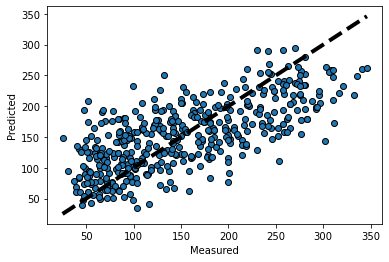

In [34]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

lr = linear_model.LinearRegression()
X, y = datasets.load_diabetes(return_X_y=True)

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()

### Ex 6. Validation croisée imbriquée versus non imbriquée

Cet exemple compare les stratégies de validation croisée non imbriquées et imbriquées sur un classifieur de l'ensemble de données de l'iris. La validation croisée (CV) imbriquée est souvent utilisée pour entraîner un modèle dans lequel les hyperparamètres doivent également être optimisés. Le CV imbriqué estime l'erreur de généralisation du modèle sous-jacent et sa recherche d'(hyper)paramètres. Le choix des paramètres qui maximisent le CV non imbriqué biaise le modèle par rapport à l'ensemble de données, ce qui donne un score trop optimiste.

La sélection de modèle sans CV imbriqué utilise les mêmes données pour régler les paramètres du modèle et évaluer les performances du modèle. L'information peut ainsi « s'infiltrer » dans le modèle et surajuster les données. L'ampleur de cet effet dépend principalement de la taille de l'ensemble de données et de la stabilité du modèle. Voir Cawley et Talbot [1] pour une analyse de ces problèmes.

Pour éviter ce problème, le CV imbriqué utilise efficacement une série de fractionnements d'ensemble d'entraînement/validation/test. Dans la boucle interne (ici exécutée par [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)), le score est approximativement maximisé en ajustant un modèle à chaque ensemble d'apprentissage, puis directement maximisé en sélectionnant des (hyper) paramètres sur l'ensemble de validation. Dans la boucle externe (ici dans [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)), l'erreur de généralisation est estimée en faisant la moyenne des scores de l'ensemble de tests sur plusieurs fractionnements d'ensembles de données.

L'exemple ci-dessous utilise un classifieur à vecteur de support avec un noyau non linéaire pour construire un modèle avec des hyperparamètres optimisés par recherche de grille. Nous comparons les performances des stratégies CV non imbriquées et imbriquées en prenant la différence entre leurs scores.

**Voir également:**
* [Validation croisée : évaluer les performances des estimateurs](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)
* [Réglage des hyper-paramètres d'un estimateur](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)

**Références:**

[1] [Cawley, G.C. ; Talbot, N.L.C. Sur le surajustement  dans la sélection du modèle et le biais de sélection ultérieur dans l'évaluation des performances. J.Mach. Learn. Rés 2010,11, 2079-2107.](https://jmlr.csail.mit.edu/papers/volume11/cawley10a/cawley10a.pdf)

Average difference of 0.007581 with std. dev. of 0.007833.


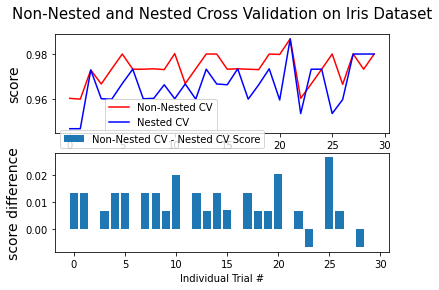

In [35]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np

# Number of random trials
NUM_TRIALS = 30

# Load the dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

## 3.1.2. Itérateurs de validation croisée

Les sections suivantes répertorient les utilitaires permettant de générer des indices pouvant être utilisés pour générer des fractionnements d'ensembles de données selon différentes stratégies de validation croisée.

### 3.1.2.1. Itérateurs de validation croisée pour données i.i.d.

Supposer que certaines données sont **indépendantes et distribuées de manière identique** (i.i.d.) suppose que tous les échantillons proviennent du même processus génératif et que le processus génératif est supposé n'avoir aucune mémoire des échantillons générés par le passé.

Les validateurs croisés suivants peuvent être utilisés dans de tels cas.

**NB** - Alors que les données i.i.d. sont une hypothèse courante dans la théorie de l'apprentissage automatique, elle tient rarement dans la pratique. Si l'on sait que les échantillons ont été générés à l'aide d'un processus dépendant du temps, il est plus sûr d'utiliser un [3.1.2.6. schéma de validation croisée sensible aux séries chronologiques](https://scikit-learn.org/stable/modules/cross_validation.html#timeseries-cv). De même, si nous savons que le processus génératif a une [3.1.2.3. structure de groupe](https://scikit-learn.org/stable/modules/cross_validation.html#group-cv) (échantillons collectés auprès de différents sujets, expériences, appareils de mesure), il est plus sûr d'utiliser la validation croisée par groupe.

#### [Exemple utilitaire préalable : Visualisation du comportement de validation croisée dans scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html)

Choisir le bon objet de validation croisée est un élément crucial pour ajuster correctement un modèle. Il existe de nombreuses façons de diviser les données en ensembles d'entraînement et de test afin d'éviter le surapprentissage du modèle, de normaliser le nombre de groupes dans les ensembles de test, etc.

Cet exemple visualise le comportement de plusieurs objets scikit-learn courants à des fins de comparaison.

In [37]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    GroupShuffleSplit,
    GroupKFold,
    StratifiedShuffleSplit,
    StratifiedGroupKFold,
)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

##### Visualisez nos données

Premièrement, nous devons comprendre la structure de nos données. Il a 100 points de données d'entrée générés aléatoirement, 3 classes réparties de manière inégale entre les points de données et 10 "groupes" répartis uniformément entre les points de données.

Comme nous le verrons, certains objets de validation croisée font des choses spécifiques avec des données étiquetées, d'autres se comportent différemment avec des données groupées, et d'autres n'utilisent pas ces informations.

Pour commencer, nous allons visualiser nos données.

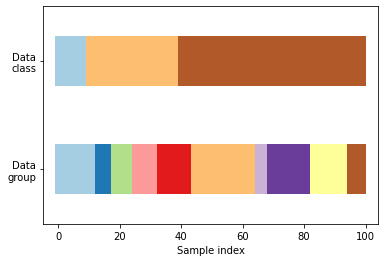

In [41]:
# Generate the class/group data
n_points = 100
X = rng.randn(100, 10)

percentiles_classes = [0.1, 0.3, 0.6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

# Generate uneven groups
group_prior = rng.dirichlet([2] * 10)
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))


def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


visualize_groups(y, groups, "no groups")

##### Définir une fonction pour visualiser le comportement de validation croisée

Nous allons définir une fonction qui nous permet de visualiser le comportement de chaque objet de validation croisée. Nous allons effectuer 4 divisions des données. Sur chaque split, nous visualiserons les indices choisis pour le training set (en bleu) et le test set (en rouge).

In [42]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

Voyons à quoi cela ressemble pour l'objet de validation croisée [`KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) :

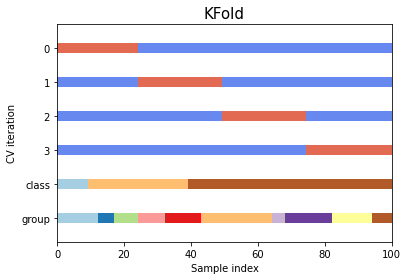

In [44]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)
plt.show()

Comme vous pouvez le constater, par défaut, l'itérateur de validation croisée KFold ne prend en compte ni la classe ni le groupe de points de données. Nous pouvons changer cela en utilisant soit:

* `StratifiedKFold` pour conserver le pourcentage d'échantillons pour chaque classe.
* `GroupKFold` pour s'assurer que le même groupe n'apparaîtra pas dans deux plis différents.
* `StratifiedGroupKFold` pour conserver la contrainte de `GroupKFold` lors de la tentative de retour de plis stratifiés.

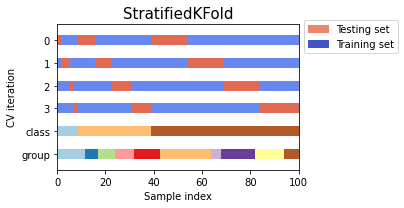

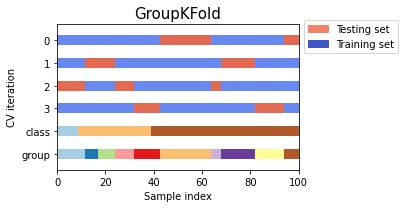

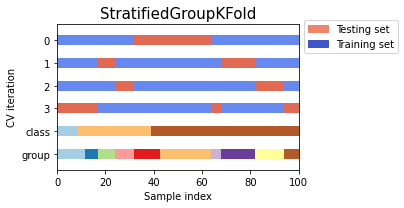

In [45]:
cvs = [StratifiedKFold, GroupKFold, StratifiedGroupKFold]

for cv in cvs:
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(cv(n_splits), X, y, groups, ax, n_splits)
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)

Ensuite, nous allons visualiser ce comportement pour un certain nombre d'itérateurs de CV.

##### Visualisez les indices de validation croisée pour de nombreux objets CV

Comparons visuellement le comportement de validation croisée pour de nombreux objets de validation croisée scikit-learn. Ci-dessous, nous allons parcourir plusieurs objets de validation croisée courants, en visualisant le comportement de chacun.

Notez comment certains utilisent les informations de groupe/classe tandis que d'autres ne le font pas.

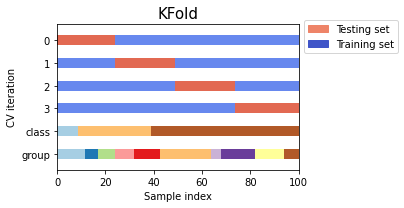

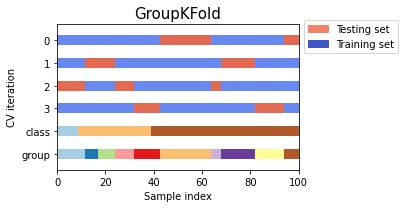

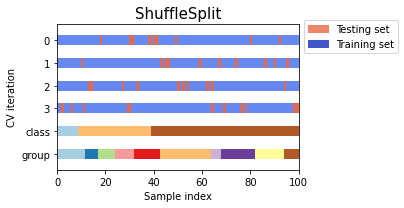

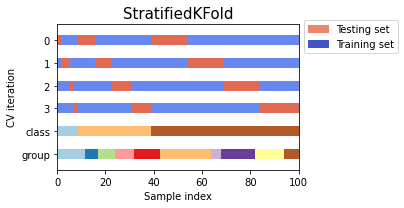

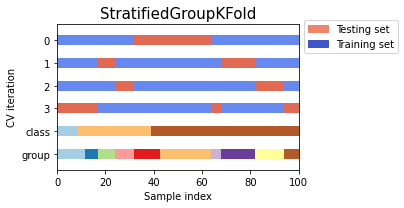

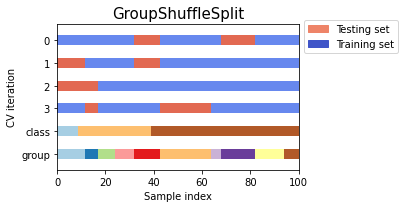

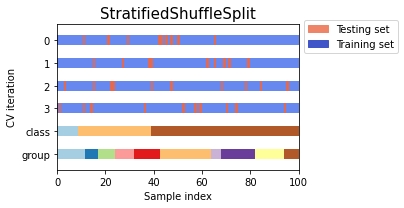

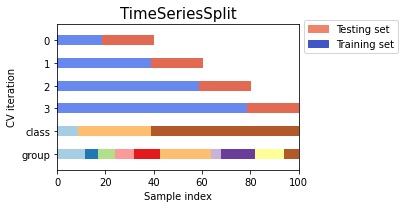

In [46]:
cvs = [
    KFold,
    GroupKFold,
    ShuffleSplit,
    StratifiedKFold,
    StratifiedGroupKFold,
    GroupShuffleSplit,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
]

for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)

plt.show()

#### K-plis

[`KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) divise tous les échantillons en $k$ groupes d'échantillons, appelés plis (si $k = n$, cela équivaut à la *stratégie Leave One Out*), de tailles égales (si possible). La fonction de prédiction est apprise en utilisant $k - 1$ plis, et le pli omis est utilisé pour le test.

Exemple de validation croisée à 2-plis sur un jeu de données avec 4 échantillons :

In [36]:
import numpy as np
from sklearn.model_selection import KFold

X = ["a", "b", "c", "d"]
kf = KFold(n_splits=2)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[2 3] [0 1]
[0 1] [2 3]


Voici une visualisation du comportement de la validation croisée. Notez que [`KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) n'est pas affecté par les classes ou les groupes.